
Cristina Acevedo

In [ ]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import math
import random
random.seed(3116)
np.random.seed(3116)


Exercise 1: Implement Decision Tree

In [ ]:
#Load dataset
cars=pd.read_csv('car.data', header=None)
cars=cars.rename(columns={0: 'buying', 1: 'maint', 2: 'doors', 3: 'persons',4: 'lug_boot',5: 'safety',6: 'class'})
cars.drop('class',inplace=True, axis=1)

In [ ]:
cars.head()

,buying,maint,doors,persons,lug_boot,safety
0,vhigh,vhigh,2,2,small,low
1,vhigh,vhigh,2,2,small,med
2,vhigh,vhigh,2,2,small,high
3,vhigh,vhigh,2,2,med,low
4,vhigh,vhigh,2,2,med,med


In [ ]:
#Pre process the dataset
cars['buying'].replace(['low', 'med', 'high', 'vhigh'], [0,1,2,3], inplace=True)
cars['maint'].replace(['low', 'med', 'high', 'vhigh'], [0,1,2,3], inplace=True)
cars['doors'].replace('5more', 5, inplace=True)
cars['persons'].replace('more', 5, inplace=True)
cars['lug_boot'].replace(['small', 'med', 'big'], [0,1,2], inplace=True)
cars['safety'].replace(['low', 'med', 'high'], [0,1,2], inplace=True)

cars['persons']=pd.to_numeric(cars['persons']) 
cars['doors']=pd.to_numeric(cars['doors']) 

In [ ]:
cars.head()

,buying,maint,doors,persons,lug_boot,safety
0,3,3,2,2,0,0
1,3,3,2,2,0,1
2,3,3,2,2,0,2
3,3,3,2,2,1,0
4,3,3,2,2,1,1


In [ ]:
cars.describe()

,buying,maint,doors,persons,lug_boot,safety
count,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000
mean,1.500000,1.500000,3.500000,3.666667,1.000000,1.000000
std,1.118358,1.118358,1.118358,1.247580,0.816733,0.816733
min,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000
25%,0.750000,0.750000,2.750000,2.000000,0.000000,0.000000
50%,1.500000,1.500000,3.500000,4.000000,1.000000,1.000000
75%,2.250000,2.250000,4.250000,5.000000,2.000000,2.000000
max,3.000000,3.000000,5.000000,5.000000,2.000000,2.000000


In [ ]:
#Divide dataset
cars = cars.sample(frac=1).reset_index(drop=True)
train, valid, test=cars[:round(len(cars)*0.7)], cars[round(len(cars)*0.7):round(len(cars)*0.7)+round(len(cars)*0.15)], cars[round(len(cars)*0.7)+round(len(cars)*0.15):]

1. Defining an appropriate stopping criteria i.e. max depth, gain is too small or reduction in cost is small

In [ ]:
def get_splits(df):
    df=df.iloc[:,:-1]
    splits=[]
    for i in range(len(df.columns)):
        possibilities=list(set(df.iloc[:,i]))
        avgs=[]
        for j in range(len(possibilities)-1):
            if np.mean(possibilities[j:j+2])>np.min(df.iloc[:,i]):
                avgs.append(np.mean(possibilities[j:j+2]))
        splits.append(avgs)

    return splits

In [ ]:
def quality_criterion(labels, classification): #Misclassification Rate: smaller is better
    labels, classification=np.array(labels), np.array(classification)
    return sum(np.array(labels!=classification))/len(labels)


In [ ]:
def split_data(df, col, split):
    group1=df[df.iloc[:,col]>=split]
    group2=df[df.iloc[:,col]<split]
    return group1, group2

In [ ]:
def find_best_split(data):
    best_quality=np.inf
    possibilities=get_splits(data)
    for i in range(len(possibilities)):
        for j in range(len(possibilities[i])):
            g1,g2=split_data(data,i,possibilities[i][j])
            if len(g1)>0 and len(g2)>0:
                max_idx1=np.argmax(Counter(g1.iloc[:,-1]).values())
                label1=list(Counter(g1.iloc[:,-1]).keys())[max_idx1]
                max_idx2=np.argmax(Counter(g2.iloc[:,-1]).values())
                label2=list(Counter(g2.iloc[:,-1]).keys())[max_idx2]
                quality=quality_criterion(np.ones(len(g1))*label1,np.array(g1.iloc[:,-1]))+quality_criterion(np.ones(len(g2))*label2,np.array(g2.iloc[:,-1]))
                if quality<best_quality:
                    best_quality=quality
                    col_split=i
                    best_split=possibilities[i][j]
    return best_quality,col_split,best_split


In [ ]:
def add_node(nodes,the_id,col,value,label,p0,p1,p2,l):
    return nodes.append({'id': the_id, 'column': col,'split_value': value,'label': label,'p0': p0,'p1':p1,'p2':p2,'l':l}, ignore_index=True)


In [ ]:
def learn_dec_tree(data, the_id, nodes, max_depth):
    if len(Counter(data.iloc[:,-1]))==1 or np.sum(get_splits(data))==0:
        counts=Counter(data.iloc[:,-1])
        label=list(counts.keys())[0]
        l=len(data)
        p0,p1,p2=counts[0],counts[1],counts[2]
        nodes=add_node(nodes,the_id,-1,-1,label,p0,p1,p2,l)
        return nodes
    else:

        q,col,value=find_best_split(data)
        g1,g2=split_data(data,col,value)
        l1=len(g1)
        l2=len(g2)
        counts1=Counter(g1.iloc[:,-1])
        counts2=Counter(g2.iloc[:,-1])


        if len(the_id+'1')<max_depth:
            p0,p1,p2=counts1[0],counts1[1],counts1[2]
            nodes=add_node(nodes,the_id+'1',col,value,-1,p0,p1,p2,l1)
            nodes=learn_dec_tree(g1,the_id+'1',nodes,max_depth)
        else:
            idx1=np.argmax(counts1.values())
            label1=list(counts1.keys())[idx1]
            p0,p1,p2=counts1[0],counts1[1],counts1[2]
            nodes=add_node(nodes,the_id+'1',-1,-1,label1,p0,p1,p2,l1)
                
        if len(the_id+'2')<max_depth:
            p0,p1,p2=counts2[0],counts2[1],counts2[2]
            nodes=add_node(nodes,the_id+'2',col,value,-1,p0,p1,p2,l2)
            nodes=learn_dec_tree(g2,the_id+'2',nodes,max_depth)
        else:
            idx2=np.argmax(counts2.values())
            label2=list(counts2.keys())[idx2]
            p0,p1,p2=counts2[0],counts2[1],counts2[2]
            nodes=add_node(nodes,the_id+'2',-1,-1,label2,p0,p1,p2,l2)


    return nodes
        

In [ ]:
#Get decision tree
nodes=pd.DataFrame(columns=['id','column','split_value','label','p0','p1','p2','l'])
nodes=learn_dec_tree(train, '1',nodes,7)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differe

The following image shows the id structure for each node. If a node doesn't divide anymore it has a label, if it divides it has a column and split value. All nodes have the probabilities for each class.

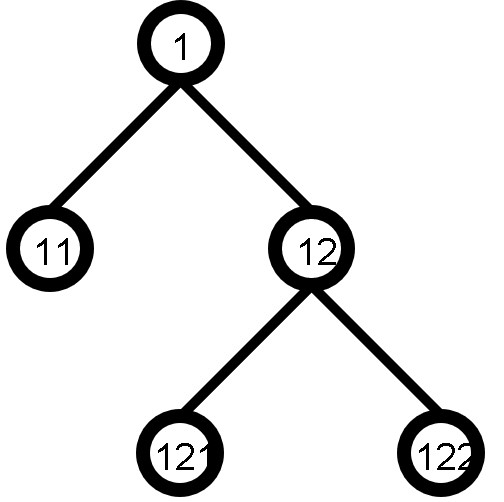

In [ ]:
#Organize the nodes to show them
nodes['id']=nodes['id'].astype('int32')
nodes=nodes.sort_values(by=['id']).reset_index(drop=True)
nodes['id']=nodes['id'].astype('str')
nodes=nodes.drop_duplicates()
nodes

,id,column,split_value,label,p0,p1,p2,l
0,11,2,4.5,-1,106,100,97,303
1,12,2,4.5,-1,297,310,300,907
2,111,0,2.5,-1,25,29,24,78
3,112,0,2.5,-1,81,71,73,225
4,121,0,2.5,-1,79,75,82,236
...,...,...,...,...,...,...,...,...
121,1222122,-1,-1.0,1,10,10,5,25
122,1222211,-1,-1.0,1,26,28,26,80
123,1222212,-1,-1.0,1,5,9,9,23
124,1222221,-1,-1.0,0,6,5,3,14


In [ ]:
def predict(nodes, data):
    classifications=nodes[nodes['label']!=-1].reset_index(drop=True)
    questions=nodes[nodes['label']==-1].reset_index(drop=True)
    predictions=[]
    ids=[]
    for i in range(len(data)):
        this_point=data.iloc[i]
        next_question='11'
        classified=False
        while classified==False:
            if next_question in list(classifications['id']):
                classified=True
                label=classifications[classifications['id']==next_question]
                label=np.array(label['label'])[0]
                predictions.append(label)
                ids.append(next_question)
            else:
                q=questions[questions['id']==next_question]
                col=q['column']
                value=q['split_value']
                if np.array(this_point.iloc[col])>=np.array(value):
                    next_question=next_question+'1'
                else:
                    next_question=next_question+'2'

    return predictions, ids

In [ ]:
#Try different max depths to find optimal tree

depth=[3,5,7,10]
best_quality=1
best_depth=0

for i in depth:
    print(i)
    nodes=pd.DataFrame(columns=['id','column','split_value','label','p0','p1','p2'])
    nodes=learn_dec_tree(train, '1',nodes, i)

    nodes['id']=nodes['id'].astype('int32')
    nodes=nodes.sort_values(by=['id']).reset_index()
    nodes['id']=nodes['id'].astype('str')
    nodes=nodes.drop_duplicates()

    preds, ids=predict(nodes, valid)
    q=quality_criterion(valid['safety'],preds)

    if q < best_quality:
        best_quality=q
        best_depth=i

print(f'The best quality was {best_quality} with depth {best_depth}')

3


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differe

5


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differe

7


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differe

10


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differe

The best quality was 0.6293436293436293 with depth 3


In [ ]:
#Get node structure of best depth 

nodes=pd.DataFrame(columns=['id','column','split_value','label'])
nodes=learn_dec_tree(train, '1',nodes, best_depth)

nodes['id']=nodes['id'].astype('int32')
nodes=nodes.sort_values(by=['id']).reset_index()
nodes['id']=nodes['id'].astype('str')
nodes=nodes.drop_duplicates()

preds, ids =predict(nodes, train)
   

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differe

1. At each decision step (or split) present the probability of each class using histogram

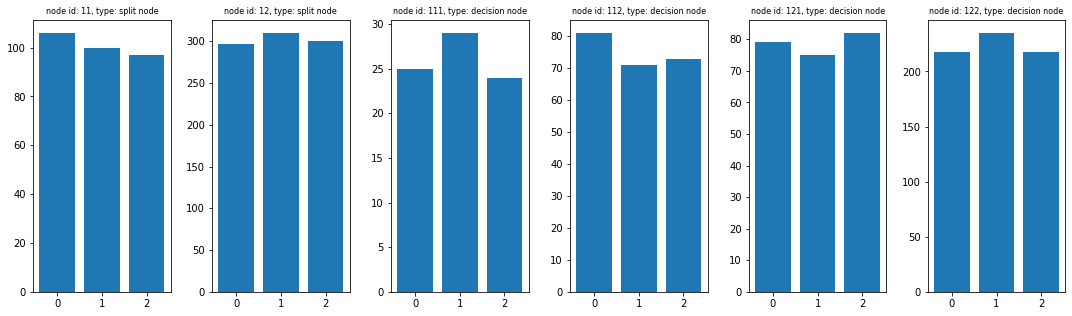

In [ ]:
hist_info=nodes[['id','label','p0','p1','p2']]
fig, ax = plt.subplots(1,6, clear=True)
fig.set_size_inches(18.5, 5)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)

for i in range(len(ax)):
  heights=hist_info[['p0','p1','p2']].iloc[i]
  ax[i].bar([0,1,2], np.array(heights))
  title='node id: '+hist_info['id'].iloc[i]
  if hist_info['label'].iloc[i]==-1:
    title+=', type: split node'
  else:
    title+=', type: decision node'

  ax[i].set_title(title,fontdict={'fontsize':8})

3. On the validation-set measure the cross entropy loss

In [ ]:
def cross_entropy_loss(label, prediction, id_prediction, nodes):
  results=[]
  probs=np.array(nodes[['p0','p1','p2']])/np.array([nodes['l'],nodes['l'],nodes['l']]).T
  cross_ent=-np.log(probs)
  ids=nodes['id']
  for i in range(len(prediction)):
    idx=np.where(ids==id_prediction[i])
    results.append(probs[idx][0][label[i]])  
  return results

In [ ]:
valid_preds, valid_ids=predict(nodes,valid)
entropies=cross_entropy_loss(np.array(valid.iloc[:,-1]),valid_preds,valid_ids,nodes)
print(f'The mean cross entropy loss is {np.mean(entropies)}')

The mean cross entropy loss is 0.33474771474771475


2. modify the Quality-criterion to Information Gain

In [ ]:
def quality_criterion(n1, n2): #Information gain: bigger is better
  probs1=n1/np.sum(n1)
  probs2=n2/np.sum(n2)

  old_probs=(n1+n2)/(np.sum(n1)+np.sum(n2))
  ent1, ent2, old_ent=0, 0, 0

  for i in range(len(probs1)):
    ent1+=-1*math.log(probs1[i],2)*probs1[i]
    ent2+=-1*math.log(probs2[i],2)*probs2[i]
    old_ent+=-1*math.log(old_probs[i],2)*old_probs[i]

  p1, p2=np.sum(n1)/(np.sum(n1)+np.sum(n2)), np.sum(n2)/(np.sum(n1)+np.sum(n2))

  return old_ent-p1*ent1-p2*ent2

In [ ]:
def find_best_split(data):
    best_quality=0
    possibilities=get_splits(data)
    for i in range(len(possibilities)):
        for j in range(len(possibilities[i])):
            g1,g2=split_data(train,i,possibilities[i][j])
            counts1=Counter(g1.iloc[:,-1])
            counts2=Counter(g2.iloc[:,-1])
            n1=np.array([counts1[0],counts1[1],counts1[2]])
            n2=np.array([counts2[0],counts2[1],counts2[2]])

            if len(g1)>0 and len(g2)>0:
              quality=quality_criterion(n1,n2)
              if quality>best_quality:
                    best_quality=quality
                    col_split=i
                    best_split=possibilities[i][j]

    return best_quality,col_split,best_split


In [ ]:
def quality_criterion_final(decision_nodes): #Information gain: bigger is better
  p0,p1,p2=decision_nodes['p0'],decision_nodes['p1'],decision_nodes['p2']
  probs0, probs1, probs2=[],[],[]
  for i in range(len(p0)):
    probs0.append(p0[i]/np.sum(np.array(decision_nodes[['p0','p1','p2']].iloc[i])))
    probs1.append(p1[i]/np.sum(np.array(decision_nodes[['p0','p1','p2']].iloc[i])))
    probs2.append(p2[i]/np.sum(np.array(decision_nodes[['p0','p1','p2']].iloc[i])))

  ent0,ent1,ent2=0,0,0
  for i in range(len(probs0)):
    if probs0[i]>0:
      ent0+=-1*math.log(probs0[i],2)*probs0[i]
    else:
      ent0+=0
    if probs1[i]>0:
      ent1+=-1*math.log(probs1[i],2)*probs1[i]
    else:
      ent1+=0
    if probs2[i]>0:
      ent2+=-1*math.log(probs2[i],2)*probs2[i]
    else:
      ent2+=0
    

  return np.mean([ent0,ent1,ent2])

In [ ]:
#Try different max depths to find optimal tree

depth=[3,5,7,10]
best_quality=0
best_depth=0

for i in depth:
    print(i)
    nodes=pd.DataFrame(columns=['id','column','split_value','label','p0','p1','p2'])
    nodes=learn_dec_tree(train, '1',nodes, i)

    nodes['id']=nodes['id'].astype('int32')
    nodes=nodes.sort_values(by=['id']).reset_index(drop=True)
    nodes['id']=nodes['id'].astype('str')
    nodes=nodes.drop_duplicates()

    decision_nodes=nodes[nodes['label']==-1]

    q=quality_criterion_final(decision_nodes.reset_index(drop=True))

    if q > best_quality:
        best_quality=q
        best_depth=i

print(f'The best quality was {best_quality} with depth {best_depth}')

3
5


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differe

7


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differe

10


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differe

The best quality was 182.063535755978 with depth 10


3. At each decision step, plot the Information Gain

In [ ]:
def add_node(nodes,the_id,col,value,label,p0,p1,p2,l,inf_gain):
    return nodes.append({'id': the_id, 'column': col,'split_value': value,'label': label,'p0': p0,'p1':p1,'p2':p2,'l':l,'inf_gain':inf_gain}, ignore_index=True)

In [ ]:
def learn_dec_tree(data, the_id, nodes, max_depth):
    if len(Counter(data.iloc[:,-1]))==1 or np.sum(get_splits(data))==0:
        counts=Counter(data.iloc[:,-1])
        label=list(counts.keys())[0]
        l=len(data)
        p0,p1,p2=counts[0],counts[1],counts[2]
        nodes=add_node(nodes,the_id,-1,-1,label,p0,p1,p2,l,0)
        return nodes
    else:

        q,col,value=find_best_split(data)
        g1,g2=split_data(data,col,value)
        l1=len(g1)
        l2=len(g2)
        counts1=Counter(g1.iloc[:,-1])
        counts2=Counter(g2.iloc[:,-1])


        if len(the_id+'1')<max_depth:
            p0,p1,p2=counts1[0],counts1[1],counts1[2]
            nodes=add_node(nodes,the_id+'1',col,value,-1,p0,p1,p2,l1,q)
            nodes=learn_dec_tree(g1,the_id+'1',nodes,max_depth)
        else:
            idx1=np.argmax(counts1.values())
            label1=list(counts1.keys())[idx1]
            p0,p1,p2=counts1[0],counts1[1],counts1[2]
            nodes=add_node(nodes,the_id+'1',-1,-1,label1,p0,p1,p2,l1,q)
                
        if len(the_id+'2')<max_depth:
            p0,p1,p2=counts2[0],counts2[1],counts2[2]
            nodes=add_node(nodes,the_id+'2',col,value,-1,p0,p1,p2,l2,q)
            nodes=learn_dec_tree(g2,the_id+'2',nodes,max_depth)
        else:
            idx2=np.argmax(counts2.values())
            label2=list(counts2.keys())[idx2]
            p0,p1,p2=counts2[0],counts2[1],counts2[2]
            nodes=add_node(nodes,the_id+'2',-1,-1,label2,p0,p1,p2,l2,q)


    return nodes

In [ ]:
nodes=pd.DataFrame(columns=['id','column','split_value','label','p0','p1','p2','l','inf_gain'])
nodes=learn_dec_tree(train, '1',nodes,best_depth)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differe

In [ ]:
element_length=np.vectorize(len)
lengths=element_length(np.array(nodes['id']))

In [ ]:
average_step_gain=[]
for i in Counter(lengths).keys():
  n=nodes[lengths==i]['inf_gain']
  average_step_gain.append(np.mean(np.array(n)))



Text(0.5, 1.0, 'Average step gain')

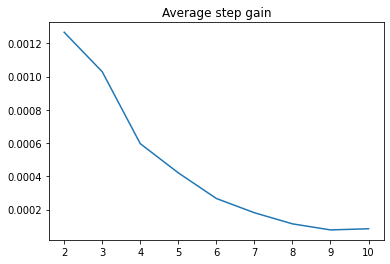

In [ ]:
plt.plot(list(Counter(lengths).keys()),average_step_gain)
plt.title('Average step gain')

4. Compare the validation set results for both Quality-criterion, output one value for test-set.

In [ ]:
def cross_entropy_loss(label, prediction, id_prediction, nodes):
  results=[]
  probs=np.array(nodes[['p0','p1','p2']])/np.array([nodes['l'],nodes['l'],nodes['l']]).T
  cross_ent=-np.log(probs.astype(float))
  ids=nodes['id']
  for i in range(len(prediction)):
    idx=np.where(ids==id_prediction[i])
    results.append(probs[idx][0][label[i]])  
  return results

In [ ]:
valid_preds, valid_ids=predict(nodes,valid)
entropies=cross_entropy_loss(np.array(valid.iloc[:,-1]),valid_preds,valid_ids,nodes)
print(f'The mean cross entropy loss is {np.mean(entropies)}')

The mean cross entropy loss is 0.32402270490505786


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


In [ ]:
test_preds, test_ids=predict(nodes,test)
entropies=cross_entropy_loss(np.array(test.iloc[:,-1]),test_preds,test_ids,nodes)
print(f'The mean cross entropy loss for test is {np.mean(entropies)}')

The mean cross entropy loss for test is 0.3513305322128852


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


The results show that the mean entropy achieved using information gain is lower, which is a sign that this model is better, as the classes are separated more appropiately. This is because the information criterion considers not only the missclassification, but the probabillity of classifying the sample correctly. Also, the entropy of the test set is a little higher, as expected because the model is slightly overfitting.

Exercise 2: Gradient Boosted Decision Trees

1. Generate a binary classification toy dataset from the scikit-learn utility "make-moons". Please gen-
erate 100 samples, for 10 different levels of noise which should give you a toy-dataset of 1000
samples.

In [ ]:
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt
import random
random.seed(3116)

In [ ]:
noise_levels=np.array(range(10))*0.01
X,Y=make_moons(n_samples=100, shuffle=True, noise=noise_levels[0], random_state=None)

for i in range(1,len(noise_levels)):
  x,y=make_moons(n_samples=100, shuffle=True, noise=noise_levels[i], random_state=None)
  X=np.vstack([X,x])
  Y=np.hstack([Y,y])


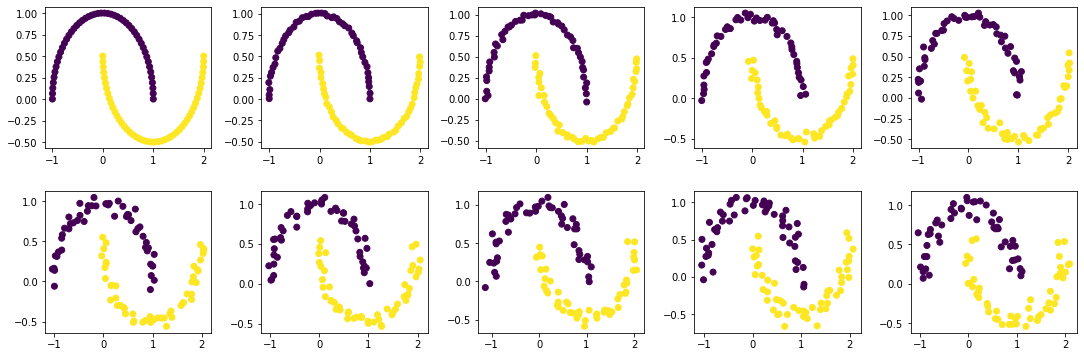

In [ ]:
# Visualize the 10 different pairs of so-called moon
fig, ax = plt.subplots(2,5, clear=True)
fig.set_size_inches(18.5, 6)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)
contador=0
for i in range(len(ax)):
  for j in range(len(ax[0])):
    ax[i][j].scatter(X[contador*100:contador*100+100,0],X[contador*100:contador*100+100,1],c=Y[contador*100:contador*100+100])
    contador=contador+1


Generate train/validation/test splits with the ratios like before

In [ ]:
l=list(range(1000))
order=random.shuffle(l)
X,Y=X[l],Y[l]

In [ ]:
x_train, x_valid, x_test=X[:round(len(X)*0.7)], X[round(len(X)*0.7):round(len(X)*0.7)+round(len(X)*0.15)], X[round(len(X)*0.7)+round(len(X)*0.15):]
y_train, y_valid, y_test=Y[:round(len(Y)*0.7)], Y[round(len(Y)*0.7):round(len(Y)*0.7)+round(len(Y)*0.15)], Y[round(len(Y)*0.7)+round(len(Y)*0.15):]

3. Please keep max depth of trees to 2 i.e root node then leaf nodes (also called stumps), and tune
number of trees in the ensemble on the validation set.

In [ ]:
def get_splits(x):
    splits=[]
    for i in range(len(x[0])):
        possibilities=list(set(x[:,i]))
        avgs=[]
        for j in range(len(possibilities)-1):
            if np.mean(possibilities[j:j+2])>np.min(x[:,i]):
                avgs.append(np.mean(possibilities[j:j+2]))
        splits.append(avgs)

    return splits

In [ ]:
def split_data(x, col, split):
    group1=np.where(x[:,col]>=split)
    group2=np.where(x[:,col]<split)

    return group1, group2

In [ ]:
def log_loss(y, prediction): #Should be smaller
    result=y*np.log(prediction)+(1-y)*np.log(1-prediction)
    return -np.nanmean(result)

In [ ]:
def find_best_split(data,labels):
    best_loss=np.inf
    possibilities=get_splits(data)
    for i in range(len(possibilities)):
        for j in range(len(possibilities[i])):
            g1,g2=split_data(data,i,possibilities[i][j])
            predictions_1=np.mean(data[g1])
            predictions_2=np.mean(data[g2])
            predictions=np.zeros(len(labels))
            predictions[g1]+=predictions_1
            predictions[g2]+=predictions_2
            loss=log_loss(labels,predictions)

            if loss<best_loss:
                col_split=i
                best_split=possibilities[i][j]
                bestg1=g1
                bestg2=g2
    return col_split,best_split, bestg1,bestg2

In [ ]:
#Initialize tree
step_size=0.001
max_trees=10

predictions=np.mean(y_train)*np.ones(len(y_train))
test_predictions=np.mean(y_train)*np.ones(len(x_test))
p=np.mean(y_train)
log_odds=np.log(p/(1-p))
probability=(np.exp(log_odds)/(1+np.exp(log_odds)))

residuals=y_train-predictions

In [ ]:
for i in range(max_trees):
  col_split,best_split, bestg1,bestg2=find_best_split(x_train,residuals)
  d1=probability*(1-probability)
  d1=d1*len(bestg1)
  d2=probability*(1-probability)
  d2=d2*len(bestg2)
  gamma1=np.sum(residuals[bestg1])/np.sum(d1)
  gamma2=np.sum(residuals[bestg2])/np.sum(d2)

  testg1,testg2=split_data(x_test, col_split, best_split)

  new_prediction=np.zeros(len(predictions))

  new_prediction[bestg1]=predictions[bestg1]+step_size*gamma1
  new_prediction[bestg2]=predictions[bestg2]+step_size*gamma2

  new_test_prediction=np.zeros(len(x_test))

  new_test_prediction[testg1]=test_predictions[testg1]+step_size*gamma1
  new_test_prediction[testg2]=test_predictions[testg2]+step_size*gamma2

  predictions=new_prediction
  test_predictions=new_test_prediction
  residuals=y_train-new_prediction
  log_odds=np.log(new_prediction/(1-new_prediction))
  test_log_odds=log_odds=np.log(new_test_prediction/(1-new_test_prediction))
  probability=(np.exp(log_odds)/(1+np.exp(log_odds)))
  test_probability=(np.exp(test_log_odds)/(1+np.exp(test_log_odds)))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


4. Report test-accuracy.

In [ ]:
def accuracy(y,predictions):
  return np.sum((y==predictions)*1)/len(y)


In [ ]:
print(f'The accuracy on the test set is {accuracy(y_test,np.round(test_probability))}')

The accuracy on the test set is 0.7733333333333333


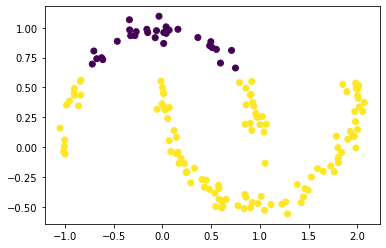

In [ ]:
plt.scatter(x_test[:,0],x_test[:,1],c=test_probability)